In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift

import warnings
warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth',200)

In [2]:
PATH = "data/"
train = pd.read_csv(PATH + 'bank-full.csv',sep = ';')
train_addition = pd.read_csv(PATH + 'bank-additional-full.csv',sep = ';')
test = pd.read_csv(PATH + 'bank.csv',sep = ';')

print(train.shape)
print(test.shape)
train.head()

(45211, 17)
(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 数据概览

In [3]:
# 空值判断
print(train.isnull().sum())
print(test.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [4]:
# 重复值判断
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
#checking types
train.dtypes.sort_values()

age           int64
previous      int64
pdays         int64
campaign      int64
duration      int64
balance       int64
day           int64
month        object
contact      object
loan         object
housing      object
default      object
education    object
marital      object
job          object
poutcome     object
y            object
dtype: object

通过观察训练集我发现：

训练集一共有45211个entries

训练集的数据比较完整，没有出现缺失值

训练集中一共有2种数据类型，int64有8个，object有9个

训练集占用的内存为 5.9+ MB


# 查看正负样本分布

In [7]:
# checking class balance
train.y.value_counts()/train.y.count()

no     0.883015
yes    0.116985
Name: y, dtype: float64

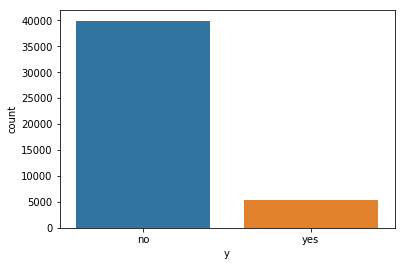

In [8]:
train.y.value_counts()
sns.countplot(x='y',data=train)  #可视化

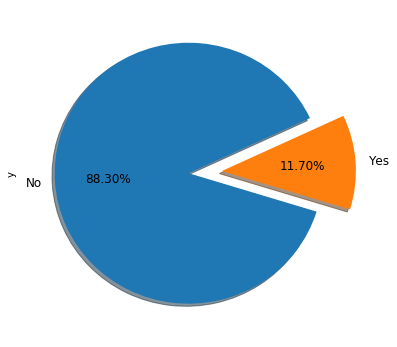

In [9]:
plt.figure(figsize=(6, 6)) 
labels ="No", "Yes"
train["y"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True,
                                             labels=labels, fontsize=12, startangle=25)

正负标签分布比例1:9左右，需要做数据采样或者调整样本权重

# 数值型特征分析（Numerical）

In [10]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


balance,duration,和pdays的std较大，说明值的分布范围较广，后期可能需要进行处理

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bcefa90>,
      dtype=object)

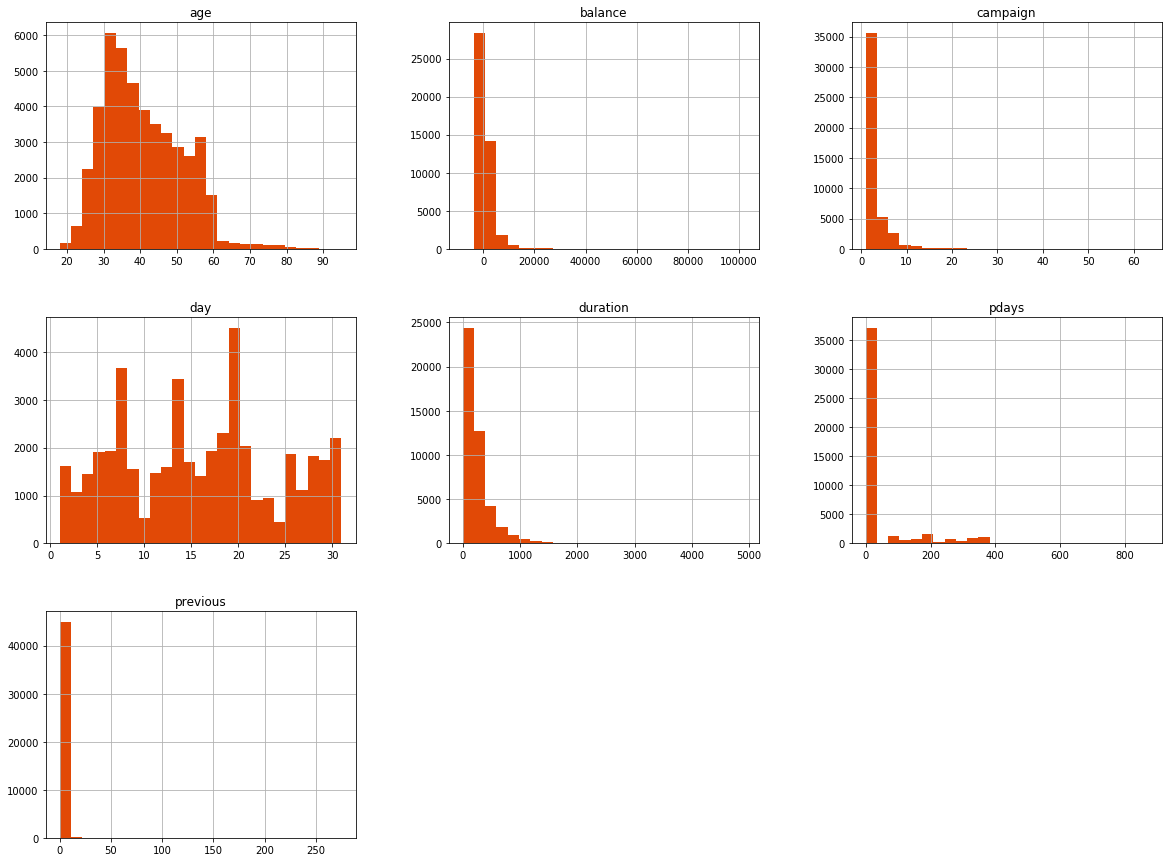

In [11]:
train.hist(bins=25, figsize=(20, 15),color='#E14906')

注意到'campaign', 'pdays','previous' 存在明显的离群点，有比较大的可能其实异常的数据点（噪声）

# 异常值检测

In [12]:
train[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,45211.000000,45211.000000,45211.000000
mean,40.197828,2.763841,0.580323
std,100.128746,3.098021,2.303441
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,-1.000000,3.000000,0.000000
max,871.000000,63.000000,275.000000


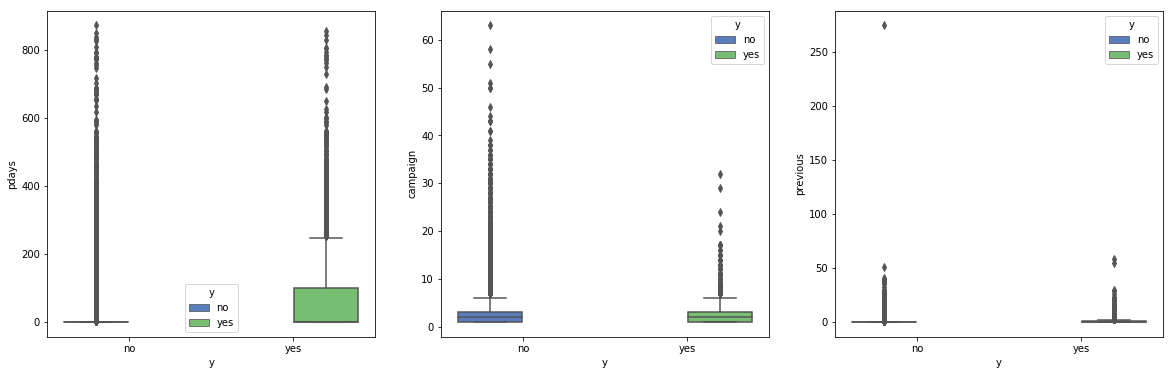

In [55]:
plt.figure(figsize=[20,6])
plt.subplot(131)
sns.boxplot(x="y", y="pdays", hue="y",data=train, palette="muted")
plt.subplot(132)
sns.boxplot(x="y", y="campaign", hue="y",data=train, palette="muted")
plt.subplot(133)
sns.boxplot(x="y", y="previous", hue="y",data=train, palette="muted")

In [13]:
# Percentage of 'pdays' values above 400:
len (train[train['pdays'] > 400] ) / len(train)

0.005175731569750724

只有0.5%的数据pdays高于400，考虑是异常值，直接删去

In [14]:
len (train[train['campaign'] > 24] ) / len(train)

0.003185065581385061

只有0.3%的数据campaign高于24，考虑是异常值，直接删去

In [46]:
len (train[train['previous'] > 24] ) / len(train)

0.0007077923514189025

只有0.07%的数据previous高于18，考虑是异常值，直接删去

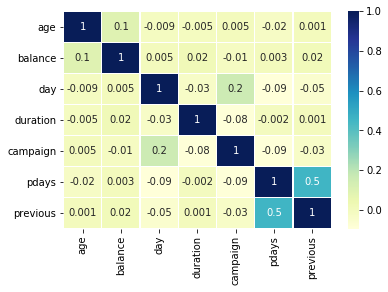

In [16]:
#Pearson’s Correlations, which measures the strength of a linear relationship
sns.heatmap(train.corr(method='pearson'), annot=True,linewidths=0.1,cmap="YlGnBu", fmt='.1g')

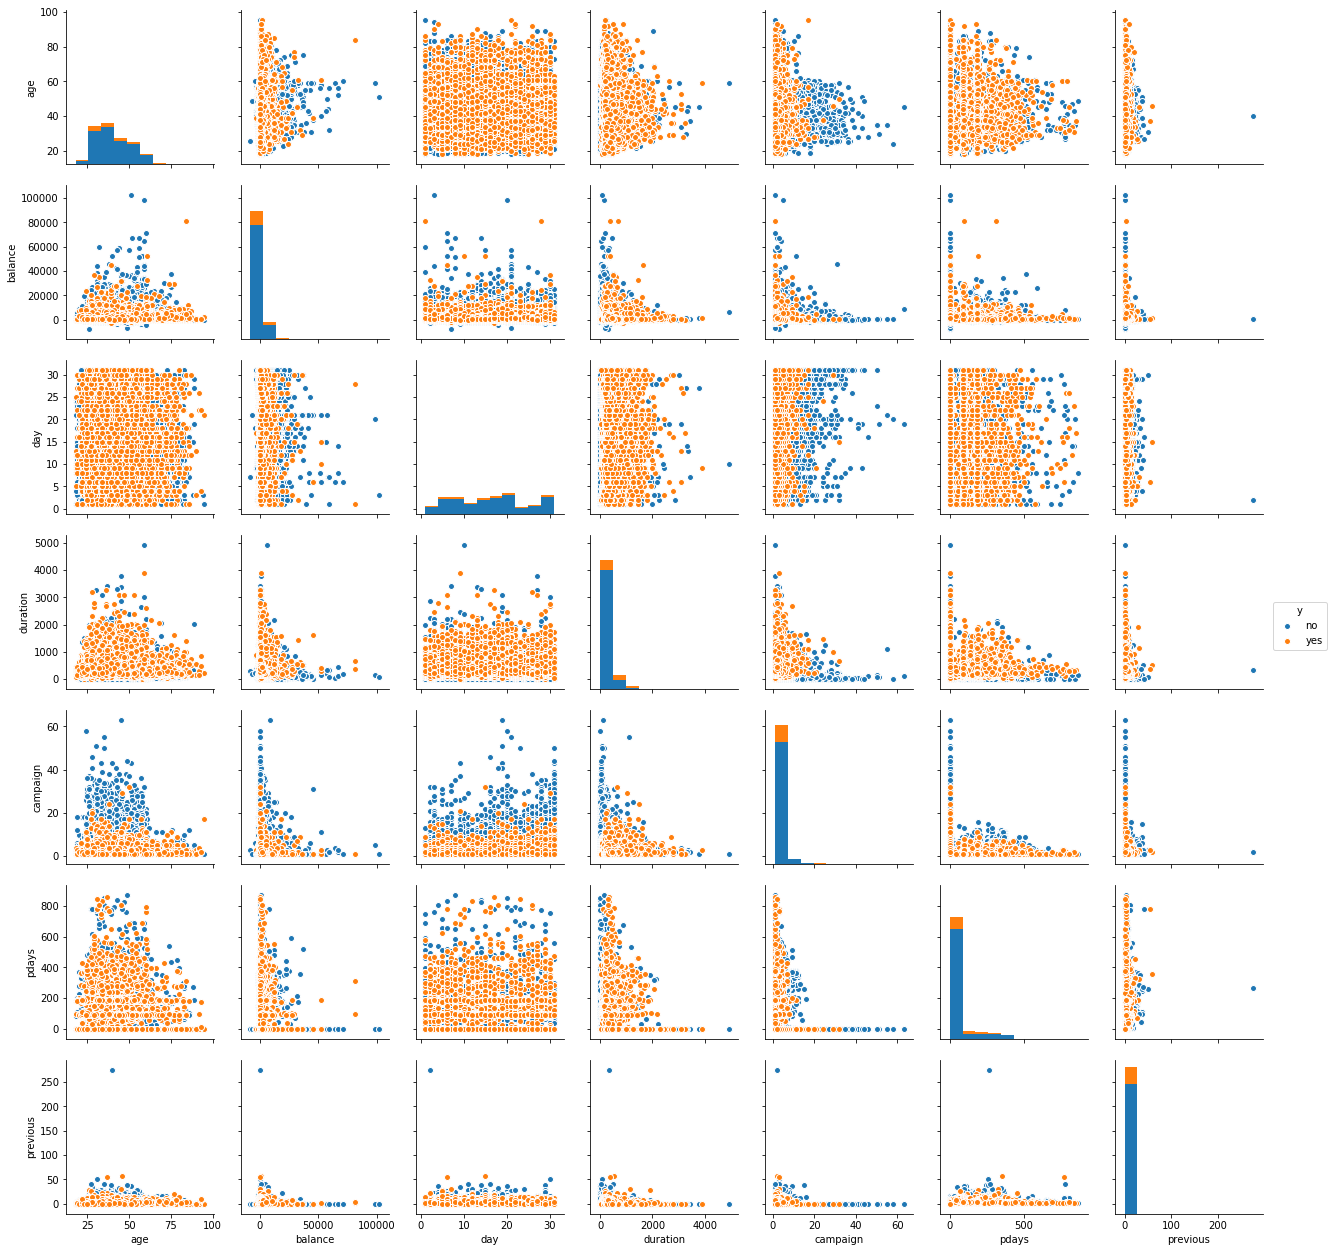

In [17]:
sns.pairplot(train, hue='y')

1. 年轻人和老年人存款意愿更高
2. balance越多的用户存款意愿更高
3. 交流时间duration越长，存款意愿更高

### Duration

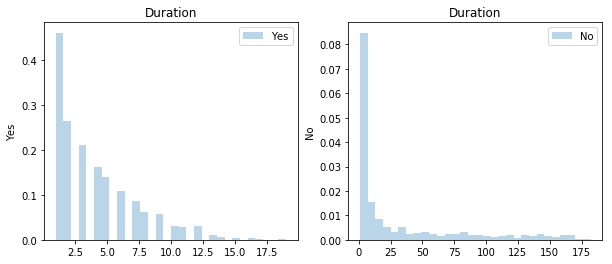

In [18]:
duration_count_yes = train[train['y']=='yes'].groupby('duration').count()['y']
duration_count_no = train[train['y']=='no'].groupby('duration').count()['y']
fig = plt.figure(figsize=(10, 4))

kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=30)
plt.subplot(121)
plt.title("Duration")
plt.ylabel('Yes')
plt.hist(duration_count_yes,label = "Yes", **kwargs)
plt.legend()
plt.subplot(122)
plt.title("Duration")
plt.ylabel('No')
plt.hist(duration_count_no,label = "No", **kwargs)
plt.legend()
plt.show()

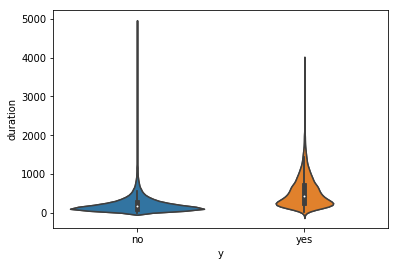

In [19]:
# 查看通话时长和是否够买的关系
sns.violinplot(x='y',y='duration',data=train)
train[train.y=='no'].duration.mean()
train[train.y=='yes'].duration.mean()
sns.violinplot(x='y',y='duration',data=train)

购买用户的通话的平均时长，大于不够买用户的平均时长。可能是因为有购买意愿的用户更愿意与工作人员多沟通。

### Age

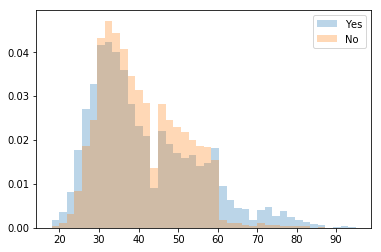

In [20]:
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(train[train['y']=='yes']['age'],label = "Yes", **kwargs)
plt.hist(train[train['y']=='no']['age'],label = "No", **kwargs)
plt.legend()
plt.show()

从年龄结构上分析，年轻人和老年人愿意存款的比例更高。

# Plots for caterical variables

In [21]:
# 查看categorical的特征
for col in train.select_dtypes(include='object').columns:
    print(col,train[col].unique())

job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome ['unknown' 'failure' 'other' 'success']
y ['no' 'yes']


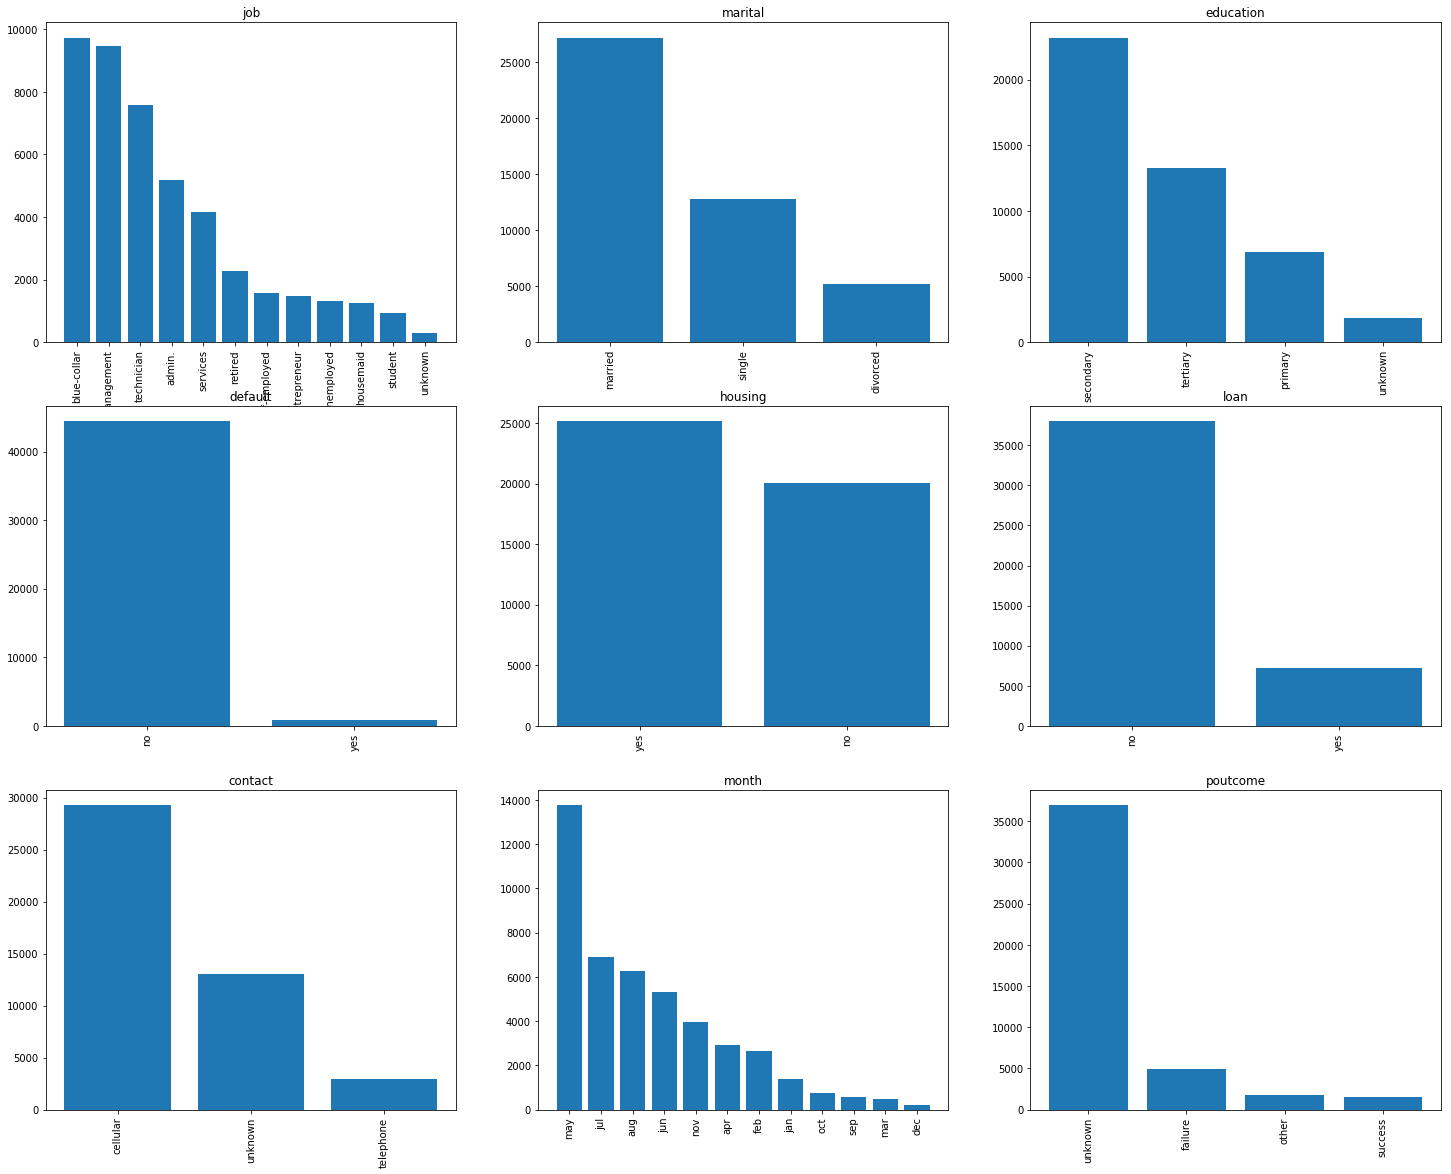

In [22]:
# 看一下各个label的占比
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(25, 20))

counter = 0
for cat_column in cat_columns:
    value_counts = train[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

In [23]:
# 查看字符型属性缺失情况
for col in train.columns:
    if train[col].dtype == object:
        print("Percentage of \"unknown\" in %s：" %col ,train[train[col] == "unknown"][col].count(),"/",train[col].count())

Percentage of "unknown" in job： 288 / 45211
Percentage of "unknown" in marital： 0 / 45211
Percentage of "unknown" in education： 1857 / 45211
Percentage of "unknown" in default： 0 / 45211
Percentage of "unknown" in housing： 0 / 45211
Percentage of "unknown" in loan： 0 / 45211
Percentage of "unknown" in contact： 13020 / 45211
Percentage of "unknown" in month： 0 / 45211
Percentage of "unknown" in poutcome： 36959 / 45211
Percentage of "unknown" in y： 0 / 45211


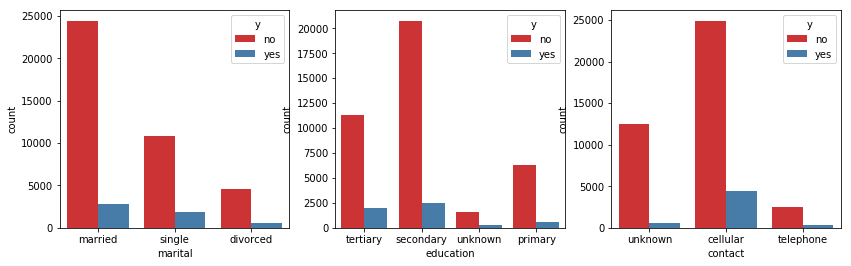

In [24]:
plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
sns.countplot(x='marital', hue='y', data=train,palette="Set1")
plt.subplot(1,3,2)
sns.countplot(x='education', hue='y', data=train,palette="Set1")
plt.subplot(1,3,3)
sns.countplot(x='contact', hue='y', data=train,palette="Set1")
plt.show()

### Marital

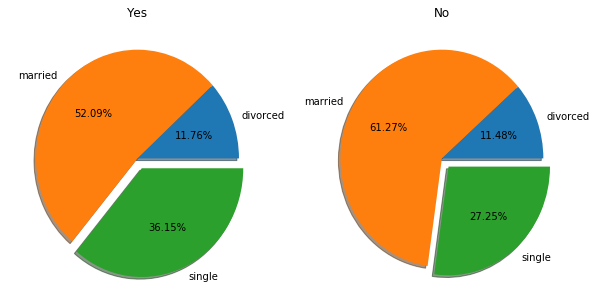

In [25]:
marital = train[train['y']=='yes'].groupby('marital').count()['y'].index
marital_count_yes = train[train['y']=='yes'].groupby('marital').count()['y']
marital_count_no = train[train['y']=='no'].groupby('marital').count()['y']
plt.figure(figsize=(10, 5)) 
plt.subplot(121)
exp = [0, 0, 0.1]
plt.title('Yes')
plt.pie(marital_count_yes.values,labels = marital,shadow=True,autopct="%0.2f%%",explode=exp)
plt.subplot(122)
plt.title('No')
plt.pie(marital_count_no.values,labels = marital,shadow=True,autopct="%0.2f%%",explode=exp)
plt.show()

相比于已婚人士（10%），单身的似乎更倾向于存款（14%），同时可以看出这个调查中已婚人士占比较大。已婚人士存款的可能性更低。

In [26]:
# import plotly.figure_factory as ff

# # Notice how divorced have a considerably low amount of balance.
# fig = ff.create_facet_grid(
#     train,
#     x='duration',
#     y='balance',
#     color_name='marital',
#     show_boxes=False,
#     marker={'size': 10, 'opacity': 1.0},
#     colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
# )

# iplot(fig, filename='facet - custom colormap')

### Education

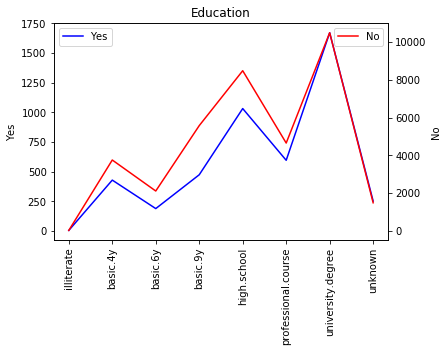

In [27]:
df = train_addition
edu =  ["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school",  "professional.course", "university.degree","unknown"]
# edu = ['tertiary','secondary','unknown','primary']
education_count_yes = df[df['y']=='yes'].groupby('education').count()['y']
education_count_no = df[df['y']=='no'].groupby('education').count()['y']
#按照学历对数据行重新排序
education_count_yes = education_count_yes.reindex(index=edu)
education_count_no = education_count_no.reindex(index=edu)

y = education_count_yes
n = education_count_no
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xticks(rotation=90)
ax1.plot(y.values,'b',label = "Yes")
ax1.set_xticks(np.arange(len(edu)))
ax1.set_xticklabels(edu)
ax1.set_ylabel('Yes')
ax1.set_title("Education")
plt.legend()
ax2 = ax1.twinx()  # this is the important function
ax2.plot(n.values, 'r',label = "No")
ax2.set_xticks(np.arange(len(edu)))
ax2.set_xticklabels(edu)
ax2.set_ylabel('No')
plt.legend()
plt.show()

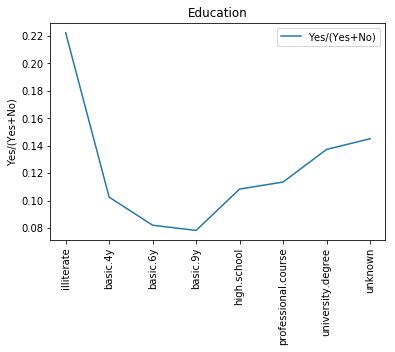

In [28]:
index = education_count_yes.index
fig = plt.figure(figsize=(6, 4))
axes=fig.add_subplot(1,1,1)
axes.plot((education_count_yes/(education_count_yes+education_count_no)).values,label = 'Yes/(Yes+No)')
axes.set_xticks(np.arange(len(edu)))
axes.set_xticklabels(edu)
axes.set_title("Education")
axes.set_ylabel('Yes/(Yes+No)')
plt.xticks(rotation=90)
plt.legend()
plt.show()


低等教育程度的人群存款欲望更低

### Contact

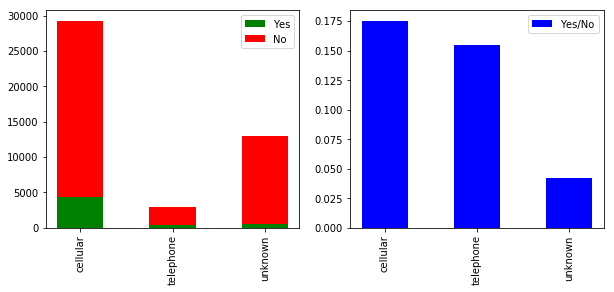

In [29]:
# for col in train.columns:
#     print(col)
col = 'contact'
job = train[train['y']=='yes'].groupby(col).count()['y'].index
job_count_yes = train[train['y']=='yes'].groupby(col).count()['y']
job_count_no = train[train['y']=='no'].groupby(col).count()['y']
width = 0.5
plt.figure(figsize=(10, 4)) 
plt.subplot(121)
plt.bar(job,job_count_yes, width, color='green', label='Yes')
plt.bar(job,job_count_no, width, bottom = job_count_yes, color='red', label='No')
plt.xticks(rotation=90)
plt.legend()
plt.subplot(122)
plt.bar(job,job_count_yes/job_count_no, width, color='blue', label='Yes/No')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Job

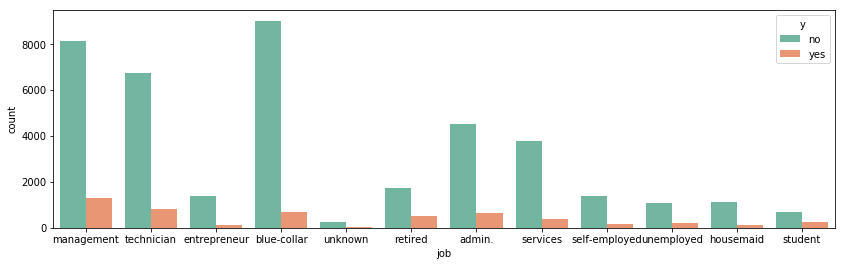

In [30]:
plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='y', data=train,palette="Set2")

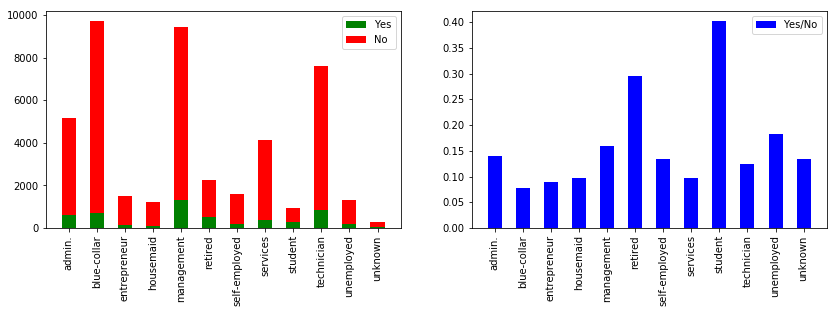

In [31]:
# for col in train.columns:
#     print(col)
col = 'job'
job = train[train['y']=='yes'].groupby(col).count()['y'].index
job_count_yes = train[train['y']=='yes'].groupby(col).count()['y']
job_count_no = train[train['y']=='no'].groupby(col).count()['y']
width = 0.5
plt.figure(figsize=(14, 4)) 
plt.subplot(121)
plt.bar(job,job_count_yes, width, color='green', label='Yes')
plt.bar(job,job_count_no, width, bottom = job_count_yes, color='red', label='No')
plt.xticks(rotation=90)
plt.legend()
plt.subplot(122)
plt.bar(job,job_count_yes/job_count_no, width, color='blue', label='Yes/No')
plt.xticks(rotation=90)
plt.legend()
plt.show()

从职业上分析，退休工人和学生存款的比例也是远远高于其他职业。

blue-collar 和 entrepreneur 存款意愿较低

### Loan/housing/default

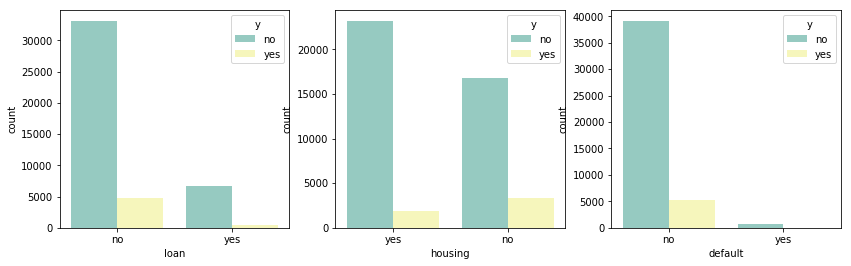

In [32]:
plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
sns.countplot(x='loan', hue='y', data=train,palette="Set3")
plt.subplot(1,3,2)
sns.countplot(x='housing', hue='y', data=train,palette="Set3")
plt.subplot(1,3,3)
sns.countplot(x='default', hue='y', data=train,palette="Set3")
plt.show()

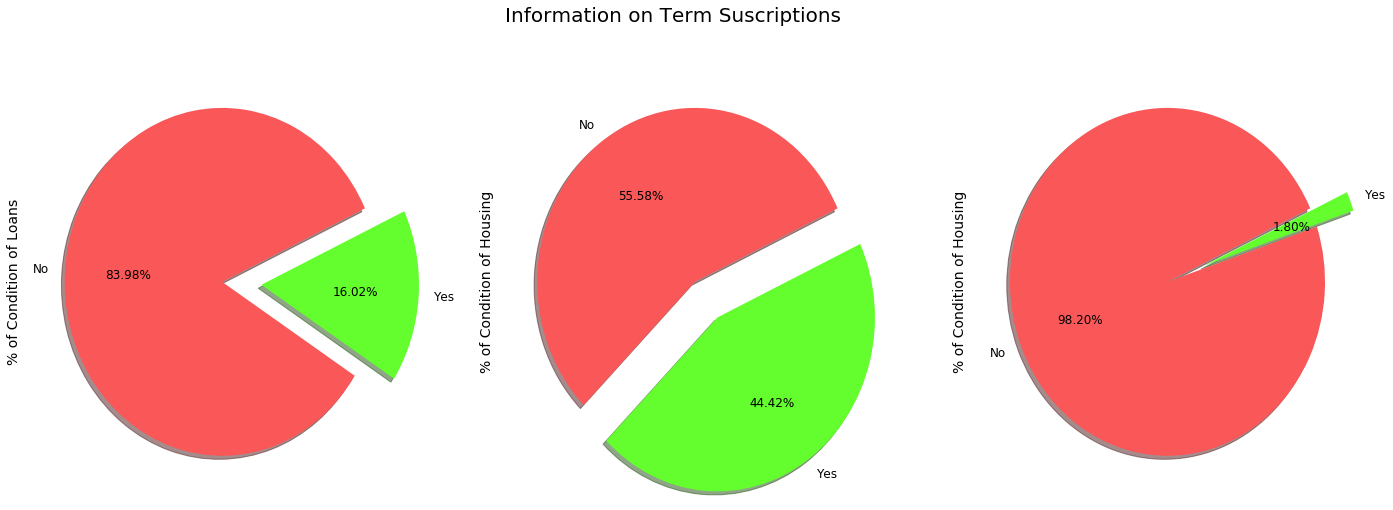

In [33]:
f, ax = plt.subplots(1,3, figsize=(24,8))

colors = ["#FA5858", "#64FE2E"]
labels ="No", "Yes"

plt.suptitle('Information on Term Suscriptions', fontsize=20)

train["loan"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

train["housing"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[1], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)
ax[1].set_ylabel('% of Condition of Housing', fontsize=14)

train["default"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[2], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)
ax[2].set_ylabel('% of Condition of Housing', fontsize=14)

plt.show()

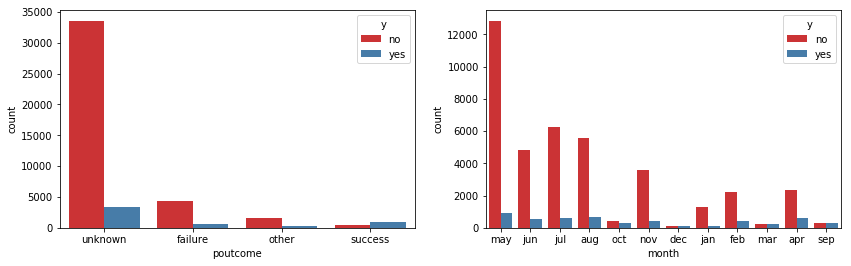

In [34]:
plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
sns.countplot(x='poutcome', hue='y', data=train,palette="Set1")
plt.subplot(1,2,2)
sns.countplot(x='month', hue='y', data=train,palette="Set1")

# 联合属性

### Age and Occuption

In [38]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
suscribed_df = train.loc[train["y"] == "yes"]

# occupations = train["job"].unique().tolist()
occupations = ['management', 'technician', 'entrepreneur', 'blue-collar','retired', 'self-employed', 'unemployed', 'housemaid', 'student']

# Get the balances by jobs
management = suscribed_df["age"].loc[suscribed_df["job"] == "management"].values
technician = suscribed_df["age"].loc[suscribed_df["job"] == "technician"].values
services = suscribed_df["age"].loc[suscribed_df["job"] == "services"].values
retired = suscribed_df["age"].loc[suscribed_df["job"] == "retired"].values
blue_collar = suscribed_df["age"].loc[suscribed_df["job"] == "blue-collar"].values
unemployed = suscribed_df["age"].loc[suscribed_df["job"] == "unemployed"].values
entrepreneur = suscribed_df["age"].loc[suscribed_df["job"] == "entrepreneur"].values
housemaid = suscribed_df["age"].loc[suscribed_df["job"] == "housemaid"].values
self_employed = suscribed_df["age"].loc[suscribed_df["job"] == "self-employed"].values
student = suscribed_df["age"].loc[suscribed_df["job"] == "student"].values


ages = [management, technician, entrepreneur,blue_collar, retired, self_employed,services, 
         unemployed, housemaid,  student]

traces = []

for xd, yd in zip(occupations, ages):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Distribution of Ages by Occupation',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(224,255,246)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [39]:
# Balance Distribution
df = train
# Create a Balance Category
df["balance_status"] = np.nan
lst = [df]

for col in lst:
    col.loc[col["balance"] < 0, "balance_status"] = "negative"
    col.loc[(col["balance"] >= 0) & (col["balance"] <= 30000), "balance_status"] = "low"
    col.loc[(col["balance"] > 30000) & (col["balance"] <= 50000), "balance_status"] = "middle"
    col.loc[col["balance"] > 50000, "balance_status"] = "high"
    
# balance by balance_status
negative = df["balance"].loc[df["balance_status"] == "negative"].values.tolist()
low = df["balance"].loc[df["balance_status"] == "low"].values.tolist()
middle = df["balance"].loc[df["balance_status"] == "middle"].values.tolist()
high = df["balance"].loc[df["balance_status"] == "high"].values.tolist()


# Get the average by occupation in each balance category
job_balance = df.groupby(['job', 'balance_status'])['balance'].mean()


trace1 = go.Barpolar(
    r=[-199.0, -392.0, -209.0, -247.0, -233.0, -270.0, -271.0, 0, -276.0, -134.5],
    text=["blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed",
         "services", "student", "technician", "unemployed"],
    name='Negative Balance',
)
trace2 = go.Barpolar(
    r=[319.5, 283.0, 212.0, 313.0, 409.0, 274.5, 308.5, 253.0, 316.0, 330.0],
    text=["blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed",
         "services", "student", "technician", "unemployed"],
    name='Low Balance',
)
trace3 = go.Barpolar(
    r=[2128.5, 2686.0, 2290.0, 2366.0, 2579.0, 2293.5, 2005.5, 2488.0, 2362.0, 1976.0],
    text=["blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed",
         "services", "student", "technician", "unemployed"],
    name='Middle Balance',
)
trace4 = go.Barpolar(
    r=[14247.5, 20138.5, 12278.5, 12956.0, 20723.0, 12159.0, 12223.0, 13107.0, 12063.0, 15107.5],
    text=["blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed",
         "services", "student", "technician", "unemployed"],
    name='High Balance',

)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    title='Mean Balance in Account<br> <i> by Job Occupation</i>',
    font=dict(
        size=12
    ),
    legend=dict(
        font=dict(
            size=16
        )
    ),
    radialaxis=dict(
        ticksuffix='%'
    ),
    orientation=270
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='polar-area-chart')

### default and balance 

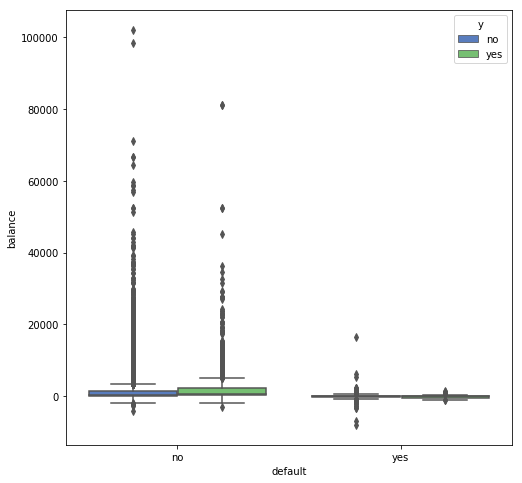

In [40]:
plt.figure(figsize=[8,8])
sns.boxplot(x="default", y="balance", hue="y",data=train, palette="muted")

# Cluster

To continue the exploration, let's search for some hidden structure on numeric variables doing a clusterization. As we don't know the number of categories, let's use MeanShift

In [ ]:
# #clustering
# scaler=StandardScaler()
# z=scaler.fit_transform(train[['balance', 'previous']])
# MS= MeanShift()
# clustering=MS.fit(z)

# #build a dataframe to examine
# labels=pd.DataFrame({'labels':clustering.labels_},index=train.index)
# df_clus=pd.concat([train[['balance', 'previous']],labels], axis=1)
# df_clus_grouped=df_clus.groupby(by='labels').mean()
# count_labels=df_clus.groupby(by='labels').size().reset_index(name='counts')
# df_clus_final=pd.concat([df_clus_grouped, count_labels], axis=1)

# print(df_clus_final.sort_values(by='balance', ascending=False))